<a href="https://colab.research.google.com/github/RunjiaChen/imageweek/blob/main/TP_Landmark_SSM_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landmark-based Statistical Shape Analysis

**Goal**: The goal of this notebook is to implement an algorithm seen today for landmark-based statistical shape analysis: PCA. Please complete the code where you see **XXXXXXXXXXXXXX** and answer the questions.

We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) which is composed of several facial images annotated with 68 landmarks (already estimated and placed). Below, you will find a picture with an example. People express two emotions, either neutral or happy.

In [6]:
pip install googledrivedownloader

In [9]:
from googledrivedownloader import download_file_from_google_drive


In [10]:
# Run this cell only if you are on google colab
download_file_from_google_drive(file_id='1C0SOYY4-uPRkHejYitRcymbocJofEBkC',
dest_path='./data/Data_FEI.npz')
download_file_from_google_drive(file_id='1FUD6LAhY-WBRviAOXJB8AQNKKyODIPR3',
dest_path='./data/facial_landmarks_68markup.jpg')
download_file_from_google_drive(file_id='1Z5dfCreR5TlBh8olMev4heeS5SbNUjqa',
dest_path='./data/aligned_shapes.npy')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

## Data loading

Now, let's load the data. If necessary, change `Working_directory` to point to the directory containing the data.

We have a list of images, the position of the landmarks (aligned to the images), the class labels Y (0 for neutral and 1 for happy) and the names of the images.

In [12]:
# Directory containing the data (you may have to change this if not on google colab):
Working_directory="./data/"

# Landmarks already aligned (by a similarity transformation = rotation, translation, scale)
aligned_landmarks = np.load('./data/aligned_shapes.npy')

# Original non-aligned landmarks with corresponding images and classes
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    Landmarks = data['Landmarks_FEI'] # original landmarks
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']

class_names = ["neutral","happy"]

In [13]:
N,M,dim = aligned_landmarks.shape # number subjects

print('Number of subjects:', N, '; Number of landmarks:',M)

Number of subjects: 400 ; Number of landmarks: 68


## Data visualization

Here, we show an example of facial landmarks

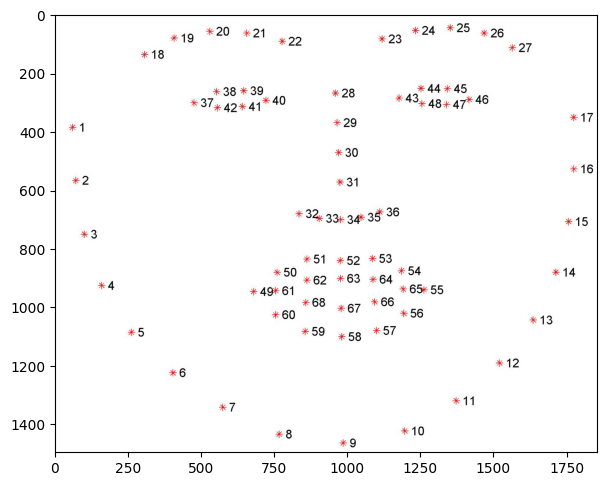

In [14]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (7,7)) # Size of the plot
plt.imshow(Example)
plt.show()

We plot 6 random images with their respective landmarks

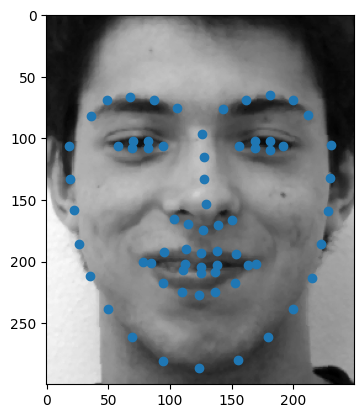

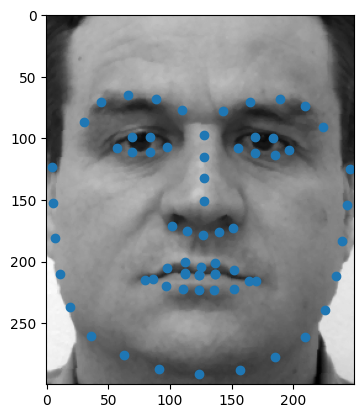

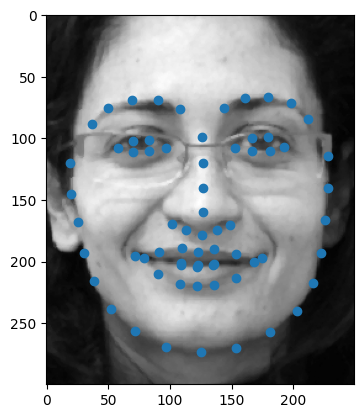

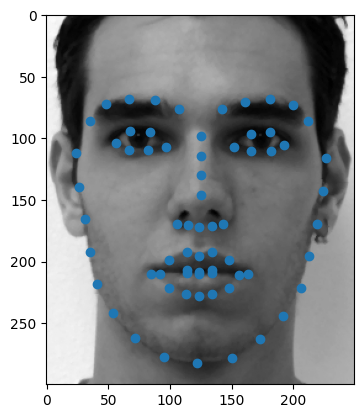

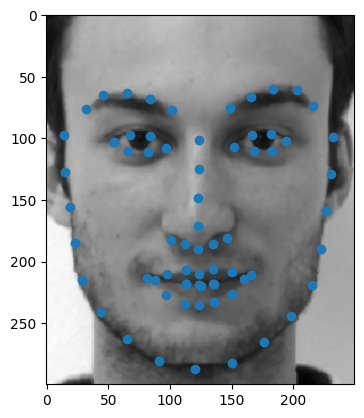

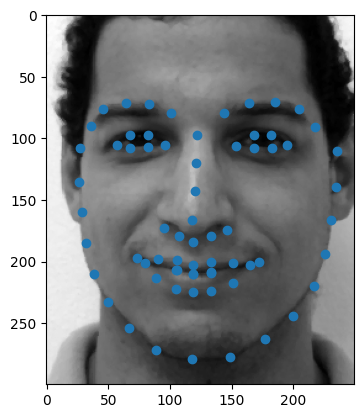

In [15]:
# plot 6 random images in the data-set
indices = np.random.randint(0, N, size=(6,))
for i in indices:
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Landmarks[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

You may notice that in the landmarks plotted above, there is some nuisance variability in addition to the variability of interest: some faces might differ up to a global rotation, scaling, or translation. This is why we do not directly use these landmarks for statistical shape analysis.<br><br>
Instead we use Generalized Procrustes Analysis as seen in the course to jointly find a mean template and perform alignment of the landmarks to this template, in terms of rotation, scale and translation. In this lab, this has already been done for you.<br><br>
The resulting aligned landmarks are stored in `aligned_landmarks` and we use them instead from now on.

## A course question

Do the following four triangles have the same shape ? Explain why ?

![shape.png](https://drive.google.com/uc?id=10OSJUfNDJ1xw6H3sRu7l3LRoojxju_4L)



## Landmark-based Statistical Shape Model: PCA

You are going to implement principal component analysis, then apply it to find the principal modes of variations in the dataset of aligned faces.

As seen in the course, an efficient way to obtain the loadings and scores output by PCA (when N > M) is by computing the Singular Value Decomposition of the centered design matrix. This method bypasses the (comparatively more expensive) computation of the sample covariance matrix of the data (`C` in the slides).

SVD is implemented in numpy.linalg: call `LA.svd(Y, full_matrices=False)`, where `Y` is the centered design matrix
* The design matrix `X` is the $(N,M)$ 'data matrix', where each row contains an $M$-dimensional sample ($N$ data samples in total)
* The centered design matrix `Y` is simply built from `X` by removing from each row of `X` the mean configuration $\frac{1}{N}\sum_{i=1}^N x_i$

In [30]:
def principal_component_analysis(X):
    """
    Input:
        X: (N,M) array where each row contains an M-dimensional data sample
    Outputs:
        Xm : (M,) array - the empirical mean of the data samples
        L: (M,K) array - a matrix where the k-th column L[:,k] is the k-th principal direction (matrix of loadings)
        Z: (N,K) array - the matrix of scores i.e., the k-th column contains the k-th principal component
            that is to say the projection of the centered data Y on the k-th column of L
        D: (K,) array - the k-th value is the variance explained by the k-th principal direction;
            this is the k-th largest eigenvalue of the matrix C defined in slide 54
        explained_variance_ratio: (K,) array - the k-th value this is the ratio of the variance explained by direction k to the
            total variance (explained by all directions)
    """
    N,M = X.shape

    # Compute the empirical mean of the data samples, aggregated in the design matrix X
    # Hint: use np.mean
    Xm = np.mean(X, axis = 0)

    # Center the design matrix X and write it in Y
    Y = X - Xm

    # Hint: sticking to the notations of slide 56, you have to call
    # R, Sigma, Wh = LA.svd(???)
    # where Wh = W.T
    R, Sigma, Wh = LA.svd(Y, full_matrices=False)

    # Compute L
    # Hint: W in slide 56 coincides with L in slide 55, because (N-1)C = Y^T Y = W Sigma^2 W^T
    L = np.transpose(Wh)

    # Compute Z
    # Hint: the column Z[:,k] contains the projections of the centered data points Y on the principal direction L[:,k]
    Z = np.matmul(Y, L)

    # Compute D, where D[k] is the k-th largest eigenvalue of C = 1/(N-1) Y^T Y = W (Sigma^2/(N-1)) W^T
    # Hint: the columns of W are orthogonal, so you can read the eigenvalues from the formula above
    D = (Sigma ** 2) / (N - 1)

    # Compute the explained_variance_ratio
    explained_variance_ratio = D / np.sum((Sigma ** 2) / (N - 1))

    # Return
    return Xm, L, Z, D, explained_variance_ratio

We are now going to apply the PCA algorithm to the `aligned_landmarks`. How to do so? Each face (among `N` faces) consists of `M` 2D landmarks $(x_m,y_m)$. We are going to arrange these `M` 2D landmarks in a big vector $(x_1,y_1,x_2,y_2,\cdots,x_M,y_M)$ of size $2M$. Each such vector will form a row in the design matrix `X`.

We will then apply the PCA algorithm to `X` to obtain a mean configuration `Xm` (a $2M$ vector), the principal directions (a $(2M,K)$ matrix), etc. To visualize the effect of the first mode of variation for instance, we can then (slide 57) compute `X_m +- 3*sqrt{D[0]}*L[:,0]`, which moves the mean configuration `Xm` in the direction of the first principal direction. This gives a $2M$ vector, which we can rearrange in a set of 2D landmarks.

The first three modes explain 29.685260, 25.140519, 12.547151 and 10.655673 of the total variability respectively
[2.96852603e+01 2.51405186e+01 1.25471507e+01 1.06556735e+01
 3.74529406e+00 3.19106970e+00 2.94090142e+00 1.97036123e+00
 1.47214646e+00 1.18466619e+00 9.27310600e-01 8.15517010e-01
 7.45372073e-01 5.68104979e-01 4.88247017e-01 3.86788986e-01
 3.58141605e-01 3.32745275e-01 3.12813037e-01 2.80825714e-01
 2.35247555e-01 2.27643089e-01 1.76859095e-01 1.63455290e-01
 1.08728979e-01 1.04190296e-01 9.90922684e-02 7.96963371e-02
 7.42041583e-02 6.73495207e-02 6.31083461e-02 6.04037061e-02
 5.22868210e-02 4.60575105e-02 4.05378801e-02 3.43387533e-02
 3.33238256e-02 3.06031801e-02 2.87014260e-02 2.38857877e-02
 2.35015749e-02 2.09628888e-02 1.86798024e-02 1.82463269e-02
 1.61961038e-02 1.53598306e-02 1.34297194e-02 1.31310737e-02
 1.25554010e-02 1.16079256e-02 1.13276982e-02 1.08174970e-02
 9.93142490e-03 9.25295485e-03 8.77124556e-03 8.19916841e-03
 8.00806108e-03 7.98432948e-03 7

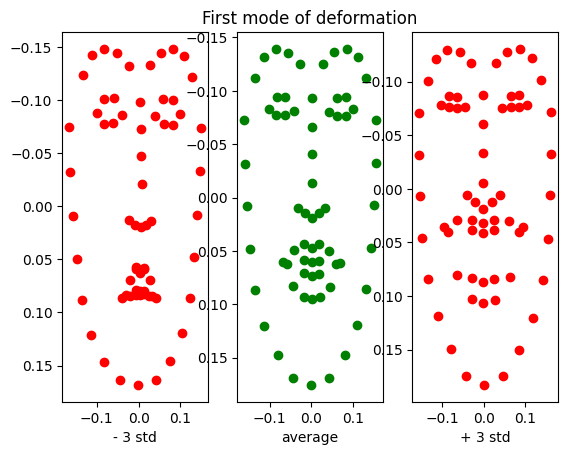

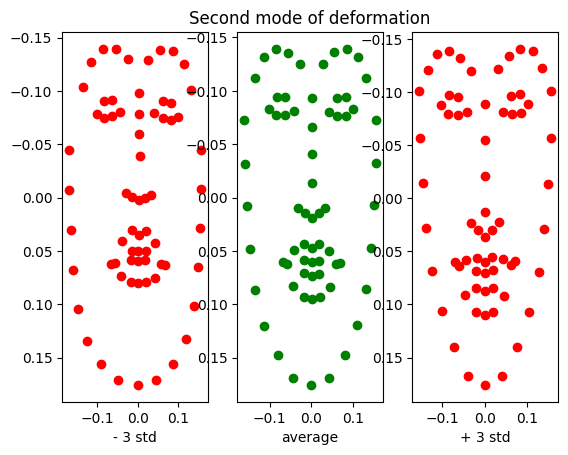

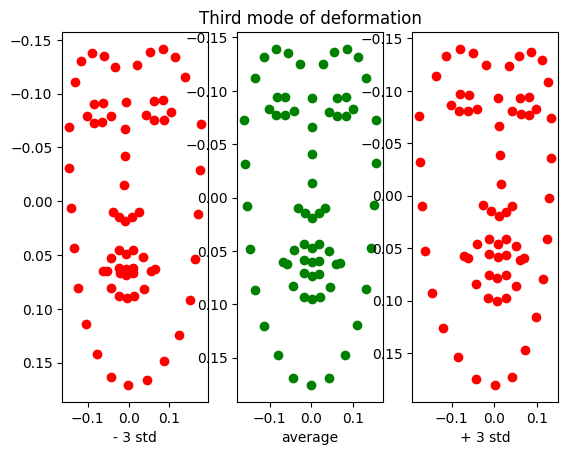

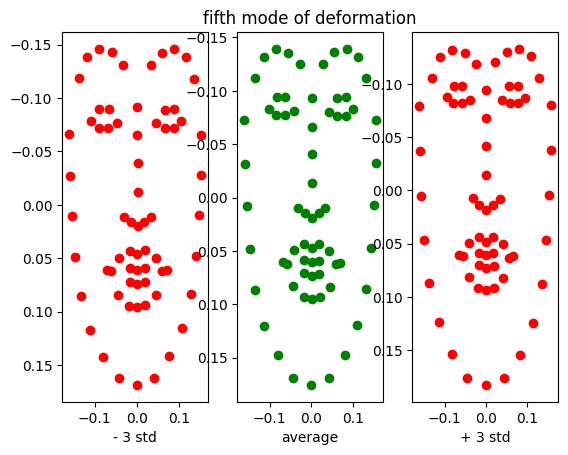

In [34]:
X = aligned_landmarks.reshape(N, 2*M)

Xm, L, Z, D, explained_variance_ratio = principal_component_analysis(X)

var_explained = explained_variance_ratio*100
print('The first three modes explain %f, %f, %f and %f of the total variability respectively' % (var_explained[0], var_explained[1], var_explained[2], var_explained[3]))

# print(var_explained)

# Compute first mode
first_mode_m= Xm - 3 * np.sqrt(D[0]) * L[:,0]
first_mode_p= Xm + 3 * np.sqrt(D[0]) * L[:,0]
# Compute second mode
second_mode_m= Xm - 3 * np.sqrt(D[1]) * L[:,1]
second_mode_p= Xm + 3 * np.sqrt(D[1]) * L[:,1]
# Compute third mode
third_mode_m= Xm - 3 * np.sqrt(D[2]) * L[:,2]
third_mode_p= Xm + 3 * np.sqrt(D[2]) * L[:,2]

# Compute fifth mode
fifth_mode_m= Xm - 3 * np.sqrt(D[4]) * L[:,4]
fifth_mode_p= Xm + 3 * np.sqrt(D[4]) * L[:,4]

plt.figure()
plt.subplot(1, 3, 1)
plt.scatter(first_mode_m[::2], first_mode_m[1::2], c='r')
plt.xlabel('- 3 std')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 2)
plt.scatter(Xm[::2], Xm[1::2], c='g')
plt.xlabel('average')
plt.title('First mode of deformation')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 3)
plt.scatter(first_mode_p[::2], first_mode_p[1::2], c='r')
plt.xlabel('+ 3 std')
plt.gca().invert_yaxis()

plt.figure()
plt.subplot(1, 3, 1)
plt.scatter(second_mode_m[::2], second_mode_m[1::2], c='r')
plt.xlabel('- 3 std')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 2)
plt.scatter(Xm[::2], Xm[1::2], c='g')
plt.xlabel('average')
plt.title('Second mode of deformation')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 3)
plt.scatter(second_mode_p[::2], second_mode_p[1::2], c='r')
plt.xlabel('+ 3 std')
plt.gca().invert_yaxis()

plt.figure()
plt.subplot(1, 3, 1)
plt.scatter(third_mode_m[::2], third_mode_m[1::2], c='r')
plt.xlabel('- 3 std')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 2)
plt.scatter(Xm[::2], Xm[1::2], c='g')
plt.xlabel('average')
plt.title('Third mode of deformation')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 3)
plt.scatter(third_mode_p[::2], third_mode_p[1::2], c='r')
plt.xlabel('+ 3 std')
plt.gca().invert_yaxis()

plt.figure()
plt.subplot(1, 3, 1)
plt.scatter(fifth_mode_m[::2], fifth_mode_m[1::2], c='r')
plt.xlabel('- 3 std')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 2)
plt.scatter(Xm[::2], Xm[1::2], c='g')
plt.xlabel('average')
plt.title('fifth mode of deformation')
plt.gca().invert_yaxis()
plt.subplot(1, 3, 3)
plt.scatter(fifth_mode_p[::2], fifth_mode_p[1::2], c='r')
plt.xlabel('+ 3 std')
plt.gca().invert_yaxis()

**QUESTIONS**


*   How many modes do you need to explain 90% of the variability ?
*   Which anatomical variability do the first three modes show ? Was it expected ?
*   How could you check whether they show an anatomically plausible deformation ?
*   Let's say that the anatomical deformation is not anatomically plausible, which kind of deformation would you use instead ? Why ?


